## Time Series Data: Top Five Zipcodes 

#### Project Submission Information
* Student name: Uma Palaniappan
* Student pace: Part Time/July Cohort
* Blog post URL: https://umapalam.github.io/time_series_data_analysis

### Background

Mercury is a company that specializes in finding housing markets in diverse areas around the United States that has the best two year return on investment for prospective home buyers. Through a combination of market research and data analysis, the company has determined that areas in the southern region of the United States are seen as a more attractive area to invest in financially. We have narrowed down the options to two states.

Zillow is a company that was founded in 2006 that contains a large amount of data on housing within the United States. Data will be used from this source for the following time series analysis. 

### Import Necessary Libraries 

In [1]:
# import statements for libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
# warnings 
import warnings 
warnings.filterwarnings("ignore")

In [51]:
# model information
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from ast import literal_eval
from sklearn.metrics import mean_squared_error

### Load Data 

In [3]:
# load Zillow CSV file 
df = pd.read_csv("zillow_data.csv")
df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


### Descriptive Statistics

In [4]:
# rename certain columns for clarity 
df.rename({'RegionName': 'Zipcode', 'RegionID':'ID', 'CountyName':'County'}, axis='columns', inplace=True)
df.head(2)

,ID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [5]:
# dimensions of the dataset
df.shape

(14723, 272)

In [6]:
# list all the columns in the dataset
df.columns

Index(['ID', 'Zipcode', 'City', 'State', 'Metro', 'County', 'SizeRank',
       '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [7]:
# basic information on dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, ID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


### Cleaning Data 

In [8]:
# focus on data from 2009 (January) to 2018 (April)
df2 = df.drop(df.ix [:,'1996-04':'2008-12'].columns, axis = 1)
df2.head(2)

,ID,Zipcode,City,State,Metro,County,SizeRank,2009-01,2009-02,2009-03,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,818300.0,814600.0,809800.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,202400.0,201700.0,201200.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [9]:
# dropping ID, Metro and SizeRank columns
df3 = df2.drop(columns=['ID','Metro','SizeRank'])
df3.head(2)

,Zipcode,City,State,County,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Cook,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Collin,202400.0,201700.0,201200.0,200700.0,200000.0,199700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [10]:
# creating a column for missing values 
cols = list(df3.columns[7:])
df3['MissingValues']= df3[cols].isna().sum(axis=1)

In [11]:
df3.head(2)

,Zipcode,City,State,County,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,MissingValues
0,60657,Chicago,IL,Cook,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,0
1,75070,McKinney,TX,Collin,202400.0,201700.0,201200.0,200700.0,200000.0,199700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,0


In [12]:
# value_counts is used for finding the missing values and grouping them by number of missing values 
df3['MissingValues'].value_counts()

0     14136
11      230
63       56
45       55
57       53
51       42
15       41
21       33
33       27
27       24
39       18
3         7
9         1
Name: MissingValues, dtype: int64

In [13]:
# get rid of entries that are not whole with >0 as a parameter
x = df3[df3['MissingValues']>0].sort_values(['MissingValues'], ascending=False)
y = x.index
df3.drop (index=y, inplace=True)

In [14]:
# check missing values again 
df3['MissingValues'].value_counts()

0    14136
Name: MissingValues, dtype: int64

In [15]:
df3.columns

Index(['Zipcode', 'City', 'State', 'County', '2009-01', '2009-02', '2009-03',
       '2009-04', '2009-05', '2009-06',
       ...
       '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
       '2018-02', '2018-03', '2018-04', 'MissingValues'],
      dtype='object', length=117)

In [16]:
# get rid of missing values column 
df4 = df3.drop(columns=['MissingValues'])
df4.head(2)

,Zipcode,City,State,County,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Cook,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Collin,202400.0,201700.0,201200.0,200700.0,200000.0,199700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


### Filter Data

In [17]:
# use groupby to isolate states 
S = df4.groupby(['State']).mean()
S.drop(['Zipcode'], axis=1, inplace=True)
S.reset_index(inplace=True)
S['Growth 2009 to 2018'] = ((S['2018-04'] - S['2009-01'])/S['2009-01'])*100

In [18]:
# filter states of Florida and North Carolina 
filter_states = ['FL','NC']
S.sort_values(by=['Growth 2009 to 2018'])  
S[S['State'].isin(filter_states)]

,State,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth 2009 to 2018
9,FL,219204.896907,215101.546392,210784.407216,206425.386598,201971.134021,197814.690722,194727.319588,192627.448454,191081.056701,...,275679.896907,277415.077320,278871.778351,279976.159794,281168.170103,282486.597938,284331.701031,286976.675258,289053.737113,31.864635
27,NC,172820.952381,172326.666667,171869.523810,171355.714286,170580.238095,169548.333333,168555.238095,167687.857143,166955.714286,...,187444.285714,188172.142857,188920.238095,189655.952381,190430.714286,191084.047619,191993.333333,193534.047619,194838.809524,12.740271


In [19]:
# filter out by county and state --- ((1)Orlando-Florida and (2)Raleigh-North Carolina)
FL = df4.loc[df4['State'] == 'FL']
NC = df4.loc[df4['State'] == 'NC']

In [20]:
FL.head(2)

,Zipcode,City,State,County,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,32162,The Villages,FL,Sumter,211900.0,210100.0,208400.0,206600.0,204800.0,203000.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
60,33160,Sunny Isles Beach,FL,Miami-Dade,894800.0,875900.0,856000.0,835500.0,812000.0,791200.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300


In [21]:
# create a seperate dataframe for each city 
Orlando = df4.loc[df4['City'] == 'Orlando']
Raleigh = df4.loc[df4['City'] == 'Raleigh']
Orlando.head(2)

,Zipcode,City,State,County,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
212,32822,Orlando,FL,Orange,141500.0,136500.0,131700.0,127300.0,122400.0,117300.0,...,173900,175900,177300,178300,179900,182200,184500,186600,189200,191400
320,32828,Orlando,FL,Orange,222700.0,218000.0,213400.0,208800.0,203900.0,199100.0,...,274500,276100,276700,277400,278800,280600,282300,284100,286500,289200


In [22]:
# find the number of unique zipcodes in Orlando 
Orlando.Zipcode.nunique()

19

In [23]:
# find the number of unique zipcodes in Raleigh
Raleigh.Zipcode.nunique()

15

### Reshape from Wide to Long Format

In [24]:
# define melt_data function for time series analysis
def melt_data(df4):
    melted = pd.melt(df4, id_vars=['Zipcode', 'City', 'State','County'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [25]:
# apply melt_data function 
Orlando_md = melt_data(Orlando)
Raleigh_md = melt_data(Raleigh)

In [26]:
# test 
Orlando_md.head(2)

,value
time,
2009-01-01,210963.157895
2009-02-01,206163.157895


### EDA - Exploratory Data Analysis and Visualization 

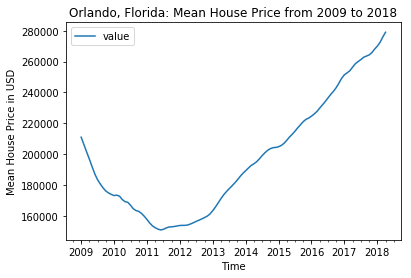

In [27]:
# plot Orlando_md
Orlando_md.plot(label ='Florida')
plt.legend()
plt.title('Orlando, Florida: Mean House Price from 2009 to 2018')
plt.ylabel('Mean House Price in USD')
plt.xlabel('Time')
plt.show()

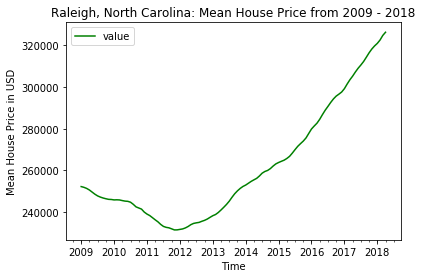

In [28]:
# plot Raleigh_md 
Raleigh_md.plot(label='North Carolina', color = 'green')
plt.legend()
plt.title('Raleigh, North Carolina: Mean House Price from 2009 - 2018')
plt.ylabel('Mean House Price in USD')
plt.xlabel('Time')
plt.show()

In [29]:
# timeseries datasets for each zipcode - Orlando 
FLO = []
for i in range(0,len(Orlando)):
    data = Orlando.iloc[[i]]
    data = melt_data(data)
    FLO.append(data)
    
FLOzipcodes = list(Orlando['Zipcode'])

In [30]:
# timeseries datasets for each zipcode - Raleigh 
NCR = []
for i in range(0,len(Raleigh)):
    data = Raleigh.iloc[[i]]
    data = melt_data(data)
    NCR.append(data)
    
NCRzipcodes = list(Raleigh['Zipcode'])

### Train Test Split

In [31]:
def train_test_split(data):
    
    train = []
    test = []
    
    for i in range(0, len(data)):
    # split datasets into training and testing
        train_df = data[i].iloc[:training_n]
        test_df = data[i].iloc[training_n:]  
    # append training and test datasets to list
        train.append(train_df)
        test.append(test_df)
    return train, test

In [32]:
# Confirm how many periods are covered by the dataset
n = len(FLO[0])
training_n = int(n*0.8)
print('Number of Obs Training Set: ', training_n)
print('Number of Obs Test Set: ', n - training_n)

Number of Obs Training Set:  89
Number of Obs Test Set:  23


In [33]:
orlando_train, orlando_test = train_test_split(FLO)
raleigh_train, raleigh_test = train_test_split(NCR)

### Stationarity and Seasonality 

In [34]:
# look at stationarity of time series
def stationarity(df, zipcode):
    
    # calculate rolling mean and standard deviation for 12 months
    rollmean = df.rolling(window=12, center=False).mean()
    rollstd = df.rolling(window=12, center=False).std()
    
    # plot rolling mean and standard deviation against the original time series data
    fig = plt.figure(figsize=(16,7))
    original = plt.plot(df, label='Original')
    mean = plt.plot(rollmean, label = 'Rolling Mean')
    std = plt.plot(rollstd, label = 'Rolling Standard Deviation')
    plt.title(f"Staionarity Check for Zipcode {zipcode}")
    plt.legend()
    plt.show(block=False)
    
    # perform dickey-fuller test on time series to find statistical measure of stationarity
    dftest = adfuller(df['value'])
    
    # parameters for test 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    #print results
    print('Results of Dickey-Fuller Test')
    print(dfoutput)

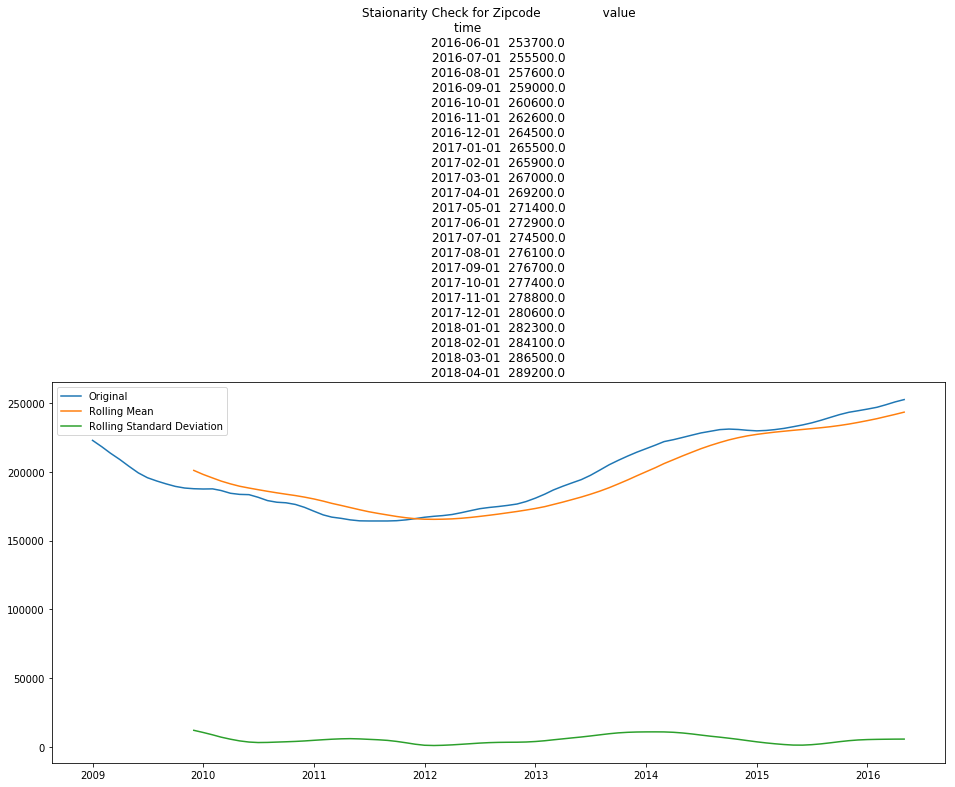

Results of Dickey-Fuller Test
Test Statistic                 -0.560569
p-value                         0.879645
#Lags Used                      8.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [35]:
stationarity(orlando_train[1], orlando_test[1])

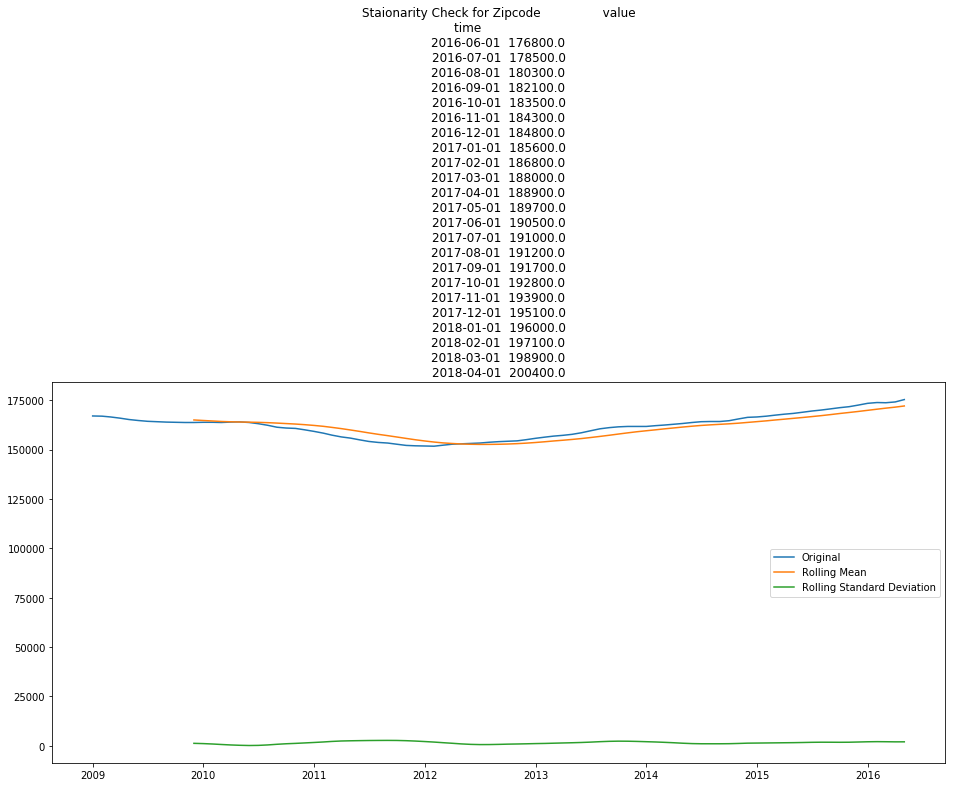

Results of Dickey-Fuller Test
Test Statistic                 -0.456413
p-value                         0.900245
#Lags Used                      3.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [36]:
stationarity(raleigh_train[3], raleigh_test[3])

Both rolling means show a trend. This means that the data is not stationary. 

In [37]:
# deal with seasonality of data 
def seasonality(df, col):
    # use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # plot trend, seasonal and residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

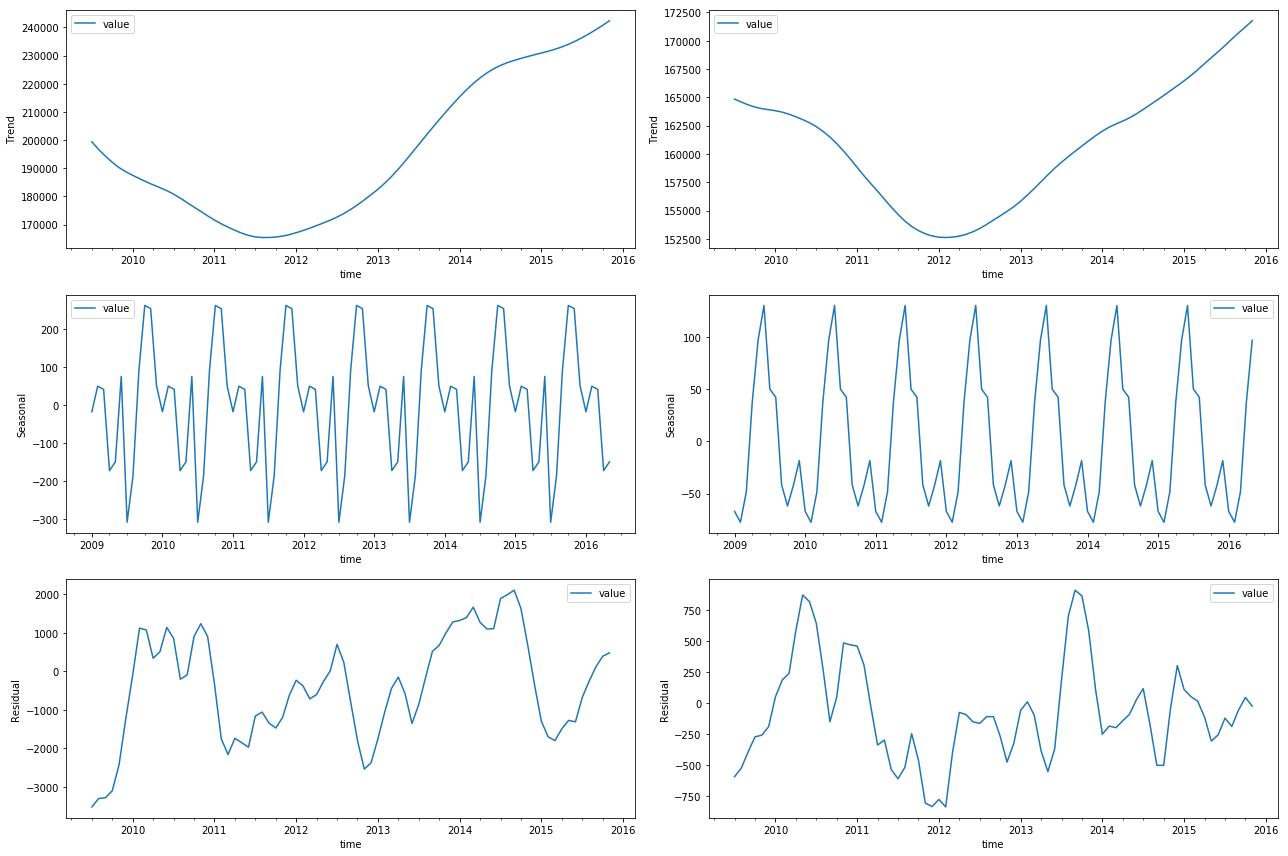

In [40]:
fig, axes = plt.subplots(3,2, figsize=(18,12))

# seasonality function 
seasonality(orlando_train[1],0)
seasonality(raleigh_train[3],1)

fig.tight_layout()
plt.show()

### Autocorrelation

In [45]:
# autocorrelation function (number of lags) - acf and pacf
def autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

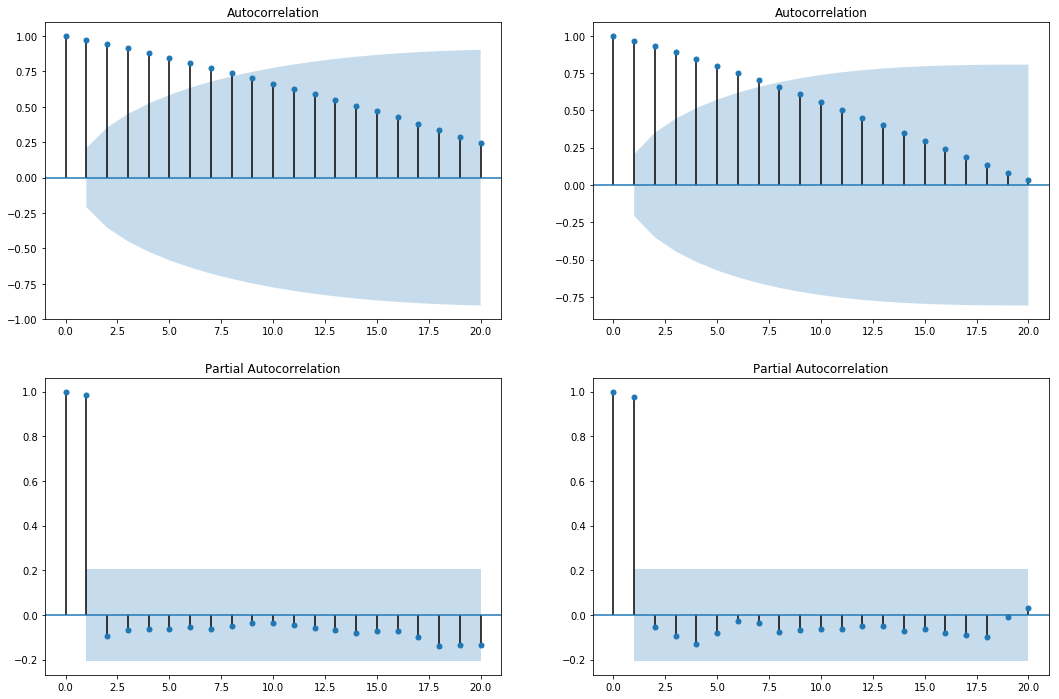

In [46]:
# the number of lags for the autocorrelation (two)
fig,ax = plt.subplots(2,2,figsize=(18,12))

autocorrelation(orlando_train[1],20, 0)
autocorrelation(raleigh_train[3],20, 1)

### Sarima Modeling 

In [49]:
# sarimax and finding parameters for sarima modeling (p,d,q)
def sarimax(df, p, d, q):
    
    # define parameters
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], 
                seasonal_order = pdqs[i], enforce_stationarity = False, 
                enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    
    return results_df

### Orlando, Florida 

In [52]:
# create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
optimal_order_orlando = []
optimal_seasonal_order_orlando = []

# for each zipcode, select the optimal order and append to respective list
for i in range(0,len(orlando_train)):
    
    optimal = sarimax(orlando_train[i], 3,2,2)
    optimal.reset_index(inplace=True)
    
    order = literal_eval(optimal['pdq'][0])
    seasonal_order = literal_eval(optimal['pdqs'][0])
    
    optimal_order_orlando.append(order)
    optimal_seasonal_order_orlando.append(seasonal_order)

In [53]:
orlando_sarima = []

# run the SARIMA model for each zipcode, append model to the empty list
for i in range(0, len(orlando_train)):
    model = sm.tsa.statespace.SARIMAX(endog=orlando_train[i], order = optimal_order_orlando[i], 
                                      seasonal_order = optimal_seasonal_order_orlando[i], 
                                      enforce_stationarity = False, 
                                      enforce_invertibility = False, freq='MS').fit()
    orlando_sarima.append(model)

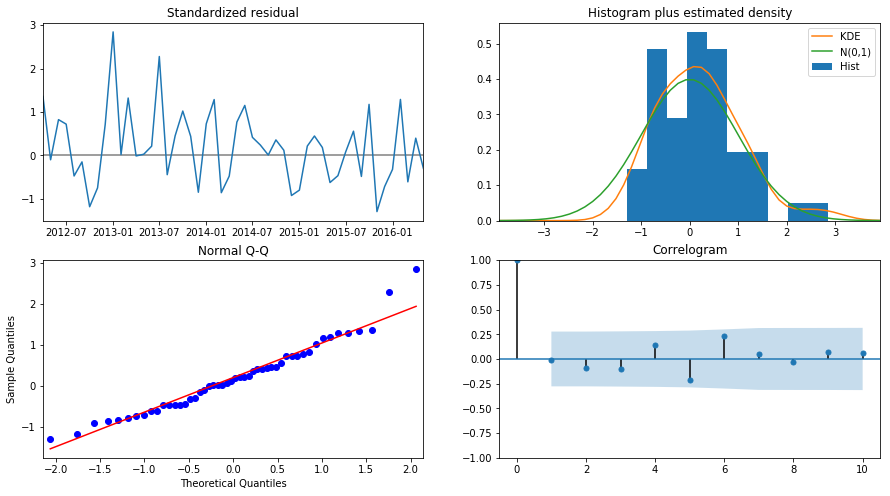

In [54]:
# run the plot_diagnostics() function
orlando_sarima[4].plot_diagnostics(figsize=(15,8))
plt.show()

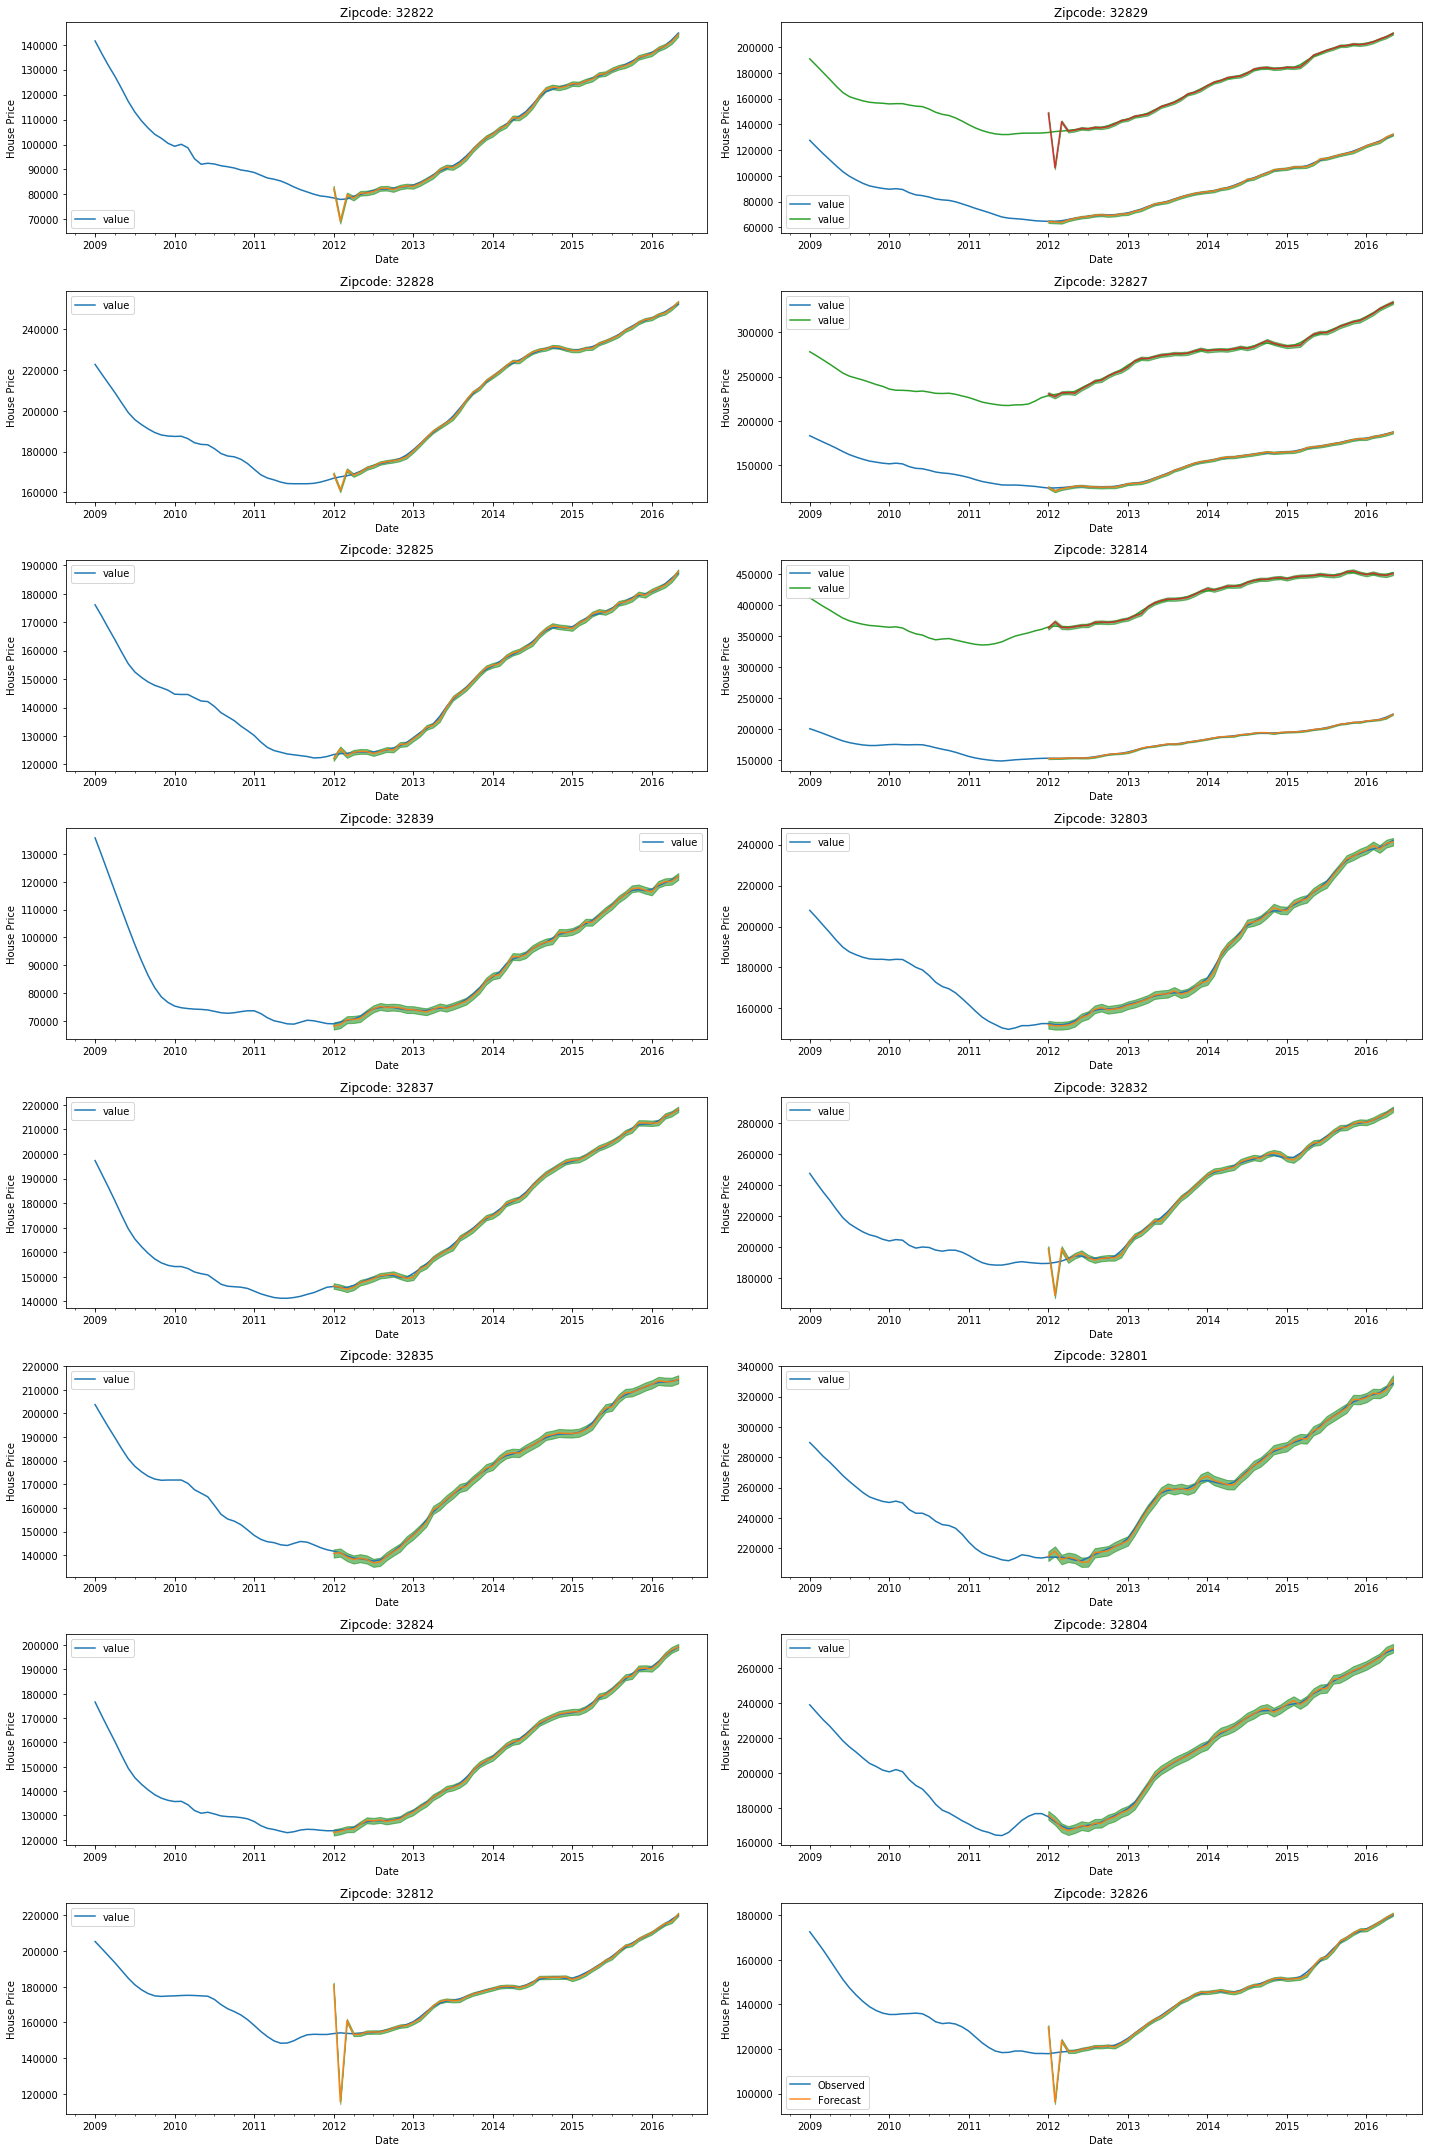

In [71]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

# specify subplot with each zipcode predicted/actual values 
for i in range(0,len(orlando_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    # generate predictions for each zipcode, starting in 2012
    pred = orlando_sarima[i].get_prediction(start='2012-01-01', dynamic=False)
    pred_conf = pred.conf_int()

    # predicted v. actual values
    orlando_train[i].plot(label='observed', ax=ax)
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    
    # title, axis labels etc
    ax.set_title(f"Zipcode: {FLOzipcodes[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
    plt.legend(['Observed', 'Forecast'])
    

plt.tight_layout()
plt.show()

In [72]:
# create empty list for rmse 
orlando_rmses = []

for i in range(0, len(orlando_train)):
    pred = orlando_sarima[i].get_prediction(start='2009-01-01', dynamic=False)
    predictions = pred.predicted_mean
    rmse = np.sqrt(mean_squared_error(predictions, orlando_train[i]))
    orlando_rmses.append({'Zipcode': FLOzipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/orlando_test[i]['2018-04']['value'][0])*100),2)})

In [64]:
orlando_rmse_df = pd.DataFrame(orlando_rmses)
orlando_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
orlando_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
11,29403.0,9.62,32803
8,18006.0,9.68,32807
10,28400.0,10.02,32806
4,26632.0,10.21,32837
9,24168.0,10.28,32817
6,24798.0,10.36,32824
2,24701.0,10.49,32825
0,20497.0,10.71,32822
3,18616.0,10.71,32839
16,27138.0,10.78,32829


In [65]:
orlando_forecasts = []

for i in range(0, len(orlando_test)):
    pred = orlando_sarima[i].forecast(n-training_n)
    orlando_forecasts.append(pred)

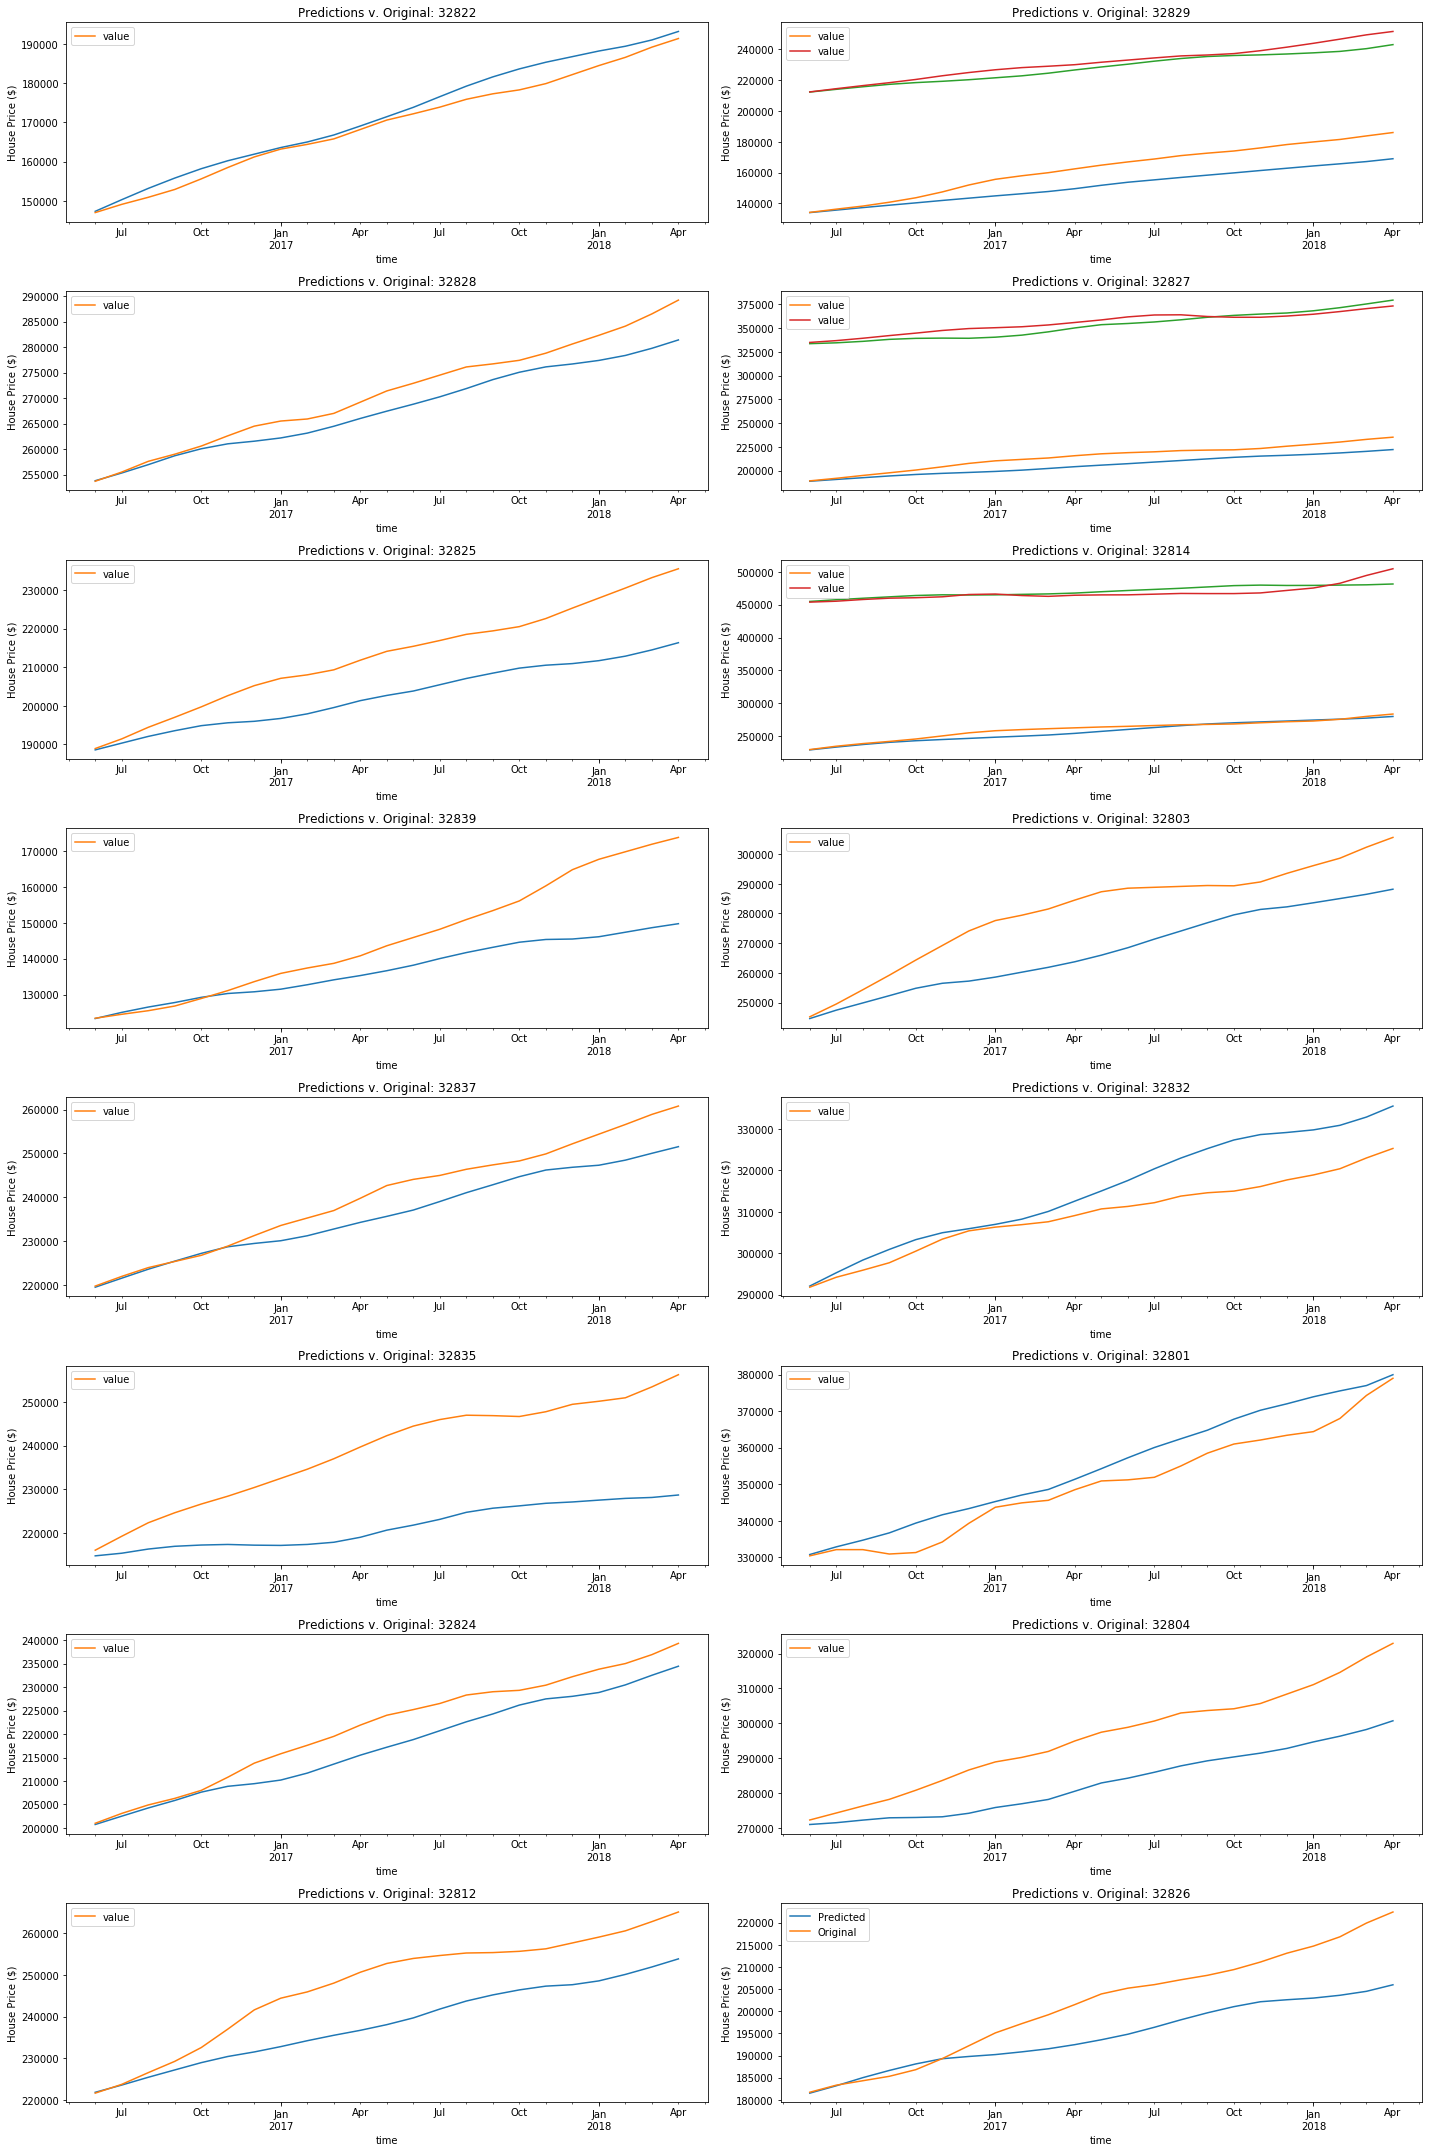

In [59]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(orlando_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    orlando_forecasts[i].plot(label='Predicted', ax=ax)
    orlando_test[i].plot(label='Original', ax=ax)
    
    ax.set_title(f"Predictions v. Original: {FLOzipcodes[i]}")
    ax.set_ylabel('House Price ($)')
    plt.legend(['Predicted', 'Original'])


plt.tight_layout()
plt.show()

In [66]:
orlando_rmses = []

for i in range(0, len(orlando_test)):
    rmse = np.sqrt(mean_squared_error(orlando_forecasts[i], orlando_test[i]))
    orlando_rmses.append({'Zipcode': FLOzipcodes[i], 'RMSE':round(rmse,0), 
                        'RMSE as % of 2018 House Price': round(((rmse/orlando_test[i]['2018-04']['value'][0])*100),2)})

In [67]:
orlando_test_rmse2 = pd.DataFrame(orlando_rmses)
orlando_test_rmse2.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
orlando_test_rmse2

,RMSE,RMSE as % of 2018 House Price,Zipcode
1,3712.0,1.28,32828
0,2766.0,1.44,32822
13,5726.0,1.51,32801
17,5787.0,1.55,32827
18,7963.0,1.58,32814
16,4364.0,1.73,32829
10,5026.0,1.77,32806
6,4500.0,1.88,32824
4,5096.0,1.95,32837
12,7352.0,2.26,32832


### Raleigh, North Carolina 

In [68]:
# create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
optimal_order_raleigh = []
optimal_seasonal_order_raleigh = []

# for each zipcode, select the optimal order and append to respective list
for i in range(0,len(raleigh_train)):
    
    optimal = sarimax(raleigh_train[i], 3,2,2)
    optimal.reset_index(inplace=True)
    
    order = literal_eval(optimal['pdq'][0])
    seasonal_order = literal_eval(optimal['pdqs'][0])
    
    optimal_order_raleigh.append(order)
    optimal_seasonal_order_raleigh.append(seasonal_order)

In [69]:
raleigh_sarima = []

# run the SARIMA model for each zipcode, append model to the empty list
for i in range(0, len(raleigh_train)):
    model = sm.tsa.statespace.SARIMAX(endog=raleigh_train[i], order = optimal_order_raleigh[i], 
                                      seasonal_order = optimal_seasonal_order_raleigh[i], 
                                      enforce_stationarity = False, 
                                      enforce_invertibility = False, freq='MS').fit()
    raleigh_sarima.append(model)

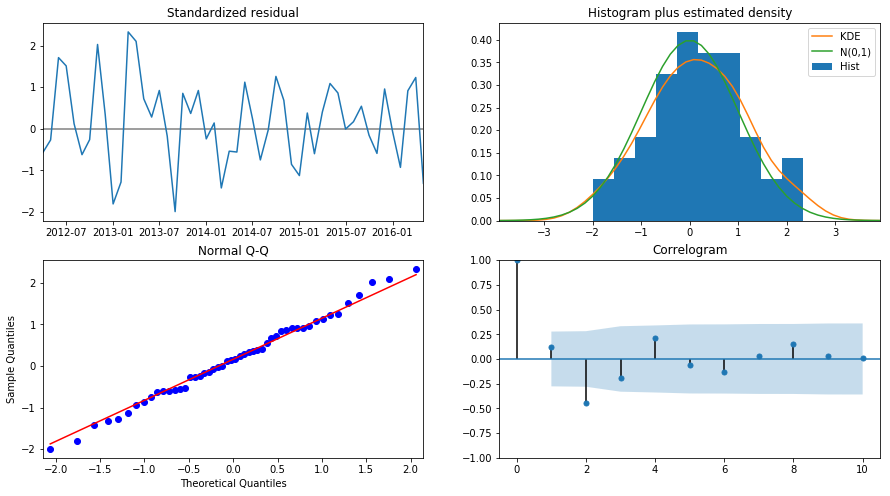

In [70]:
# run the plot_diagnostics() function
raleigh_sarima[4].plot_diagnostics(figsize=(15,8))
plt.show()

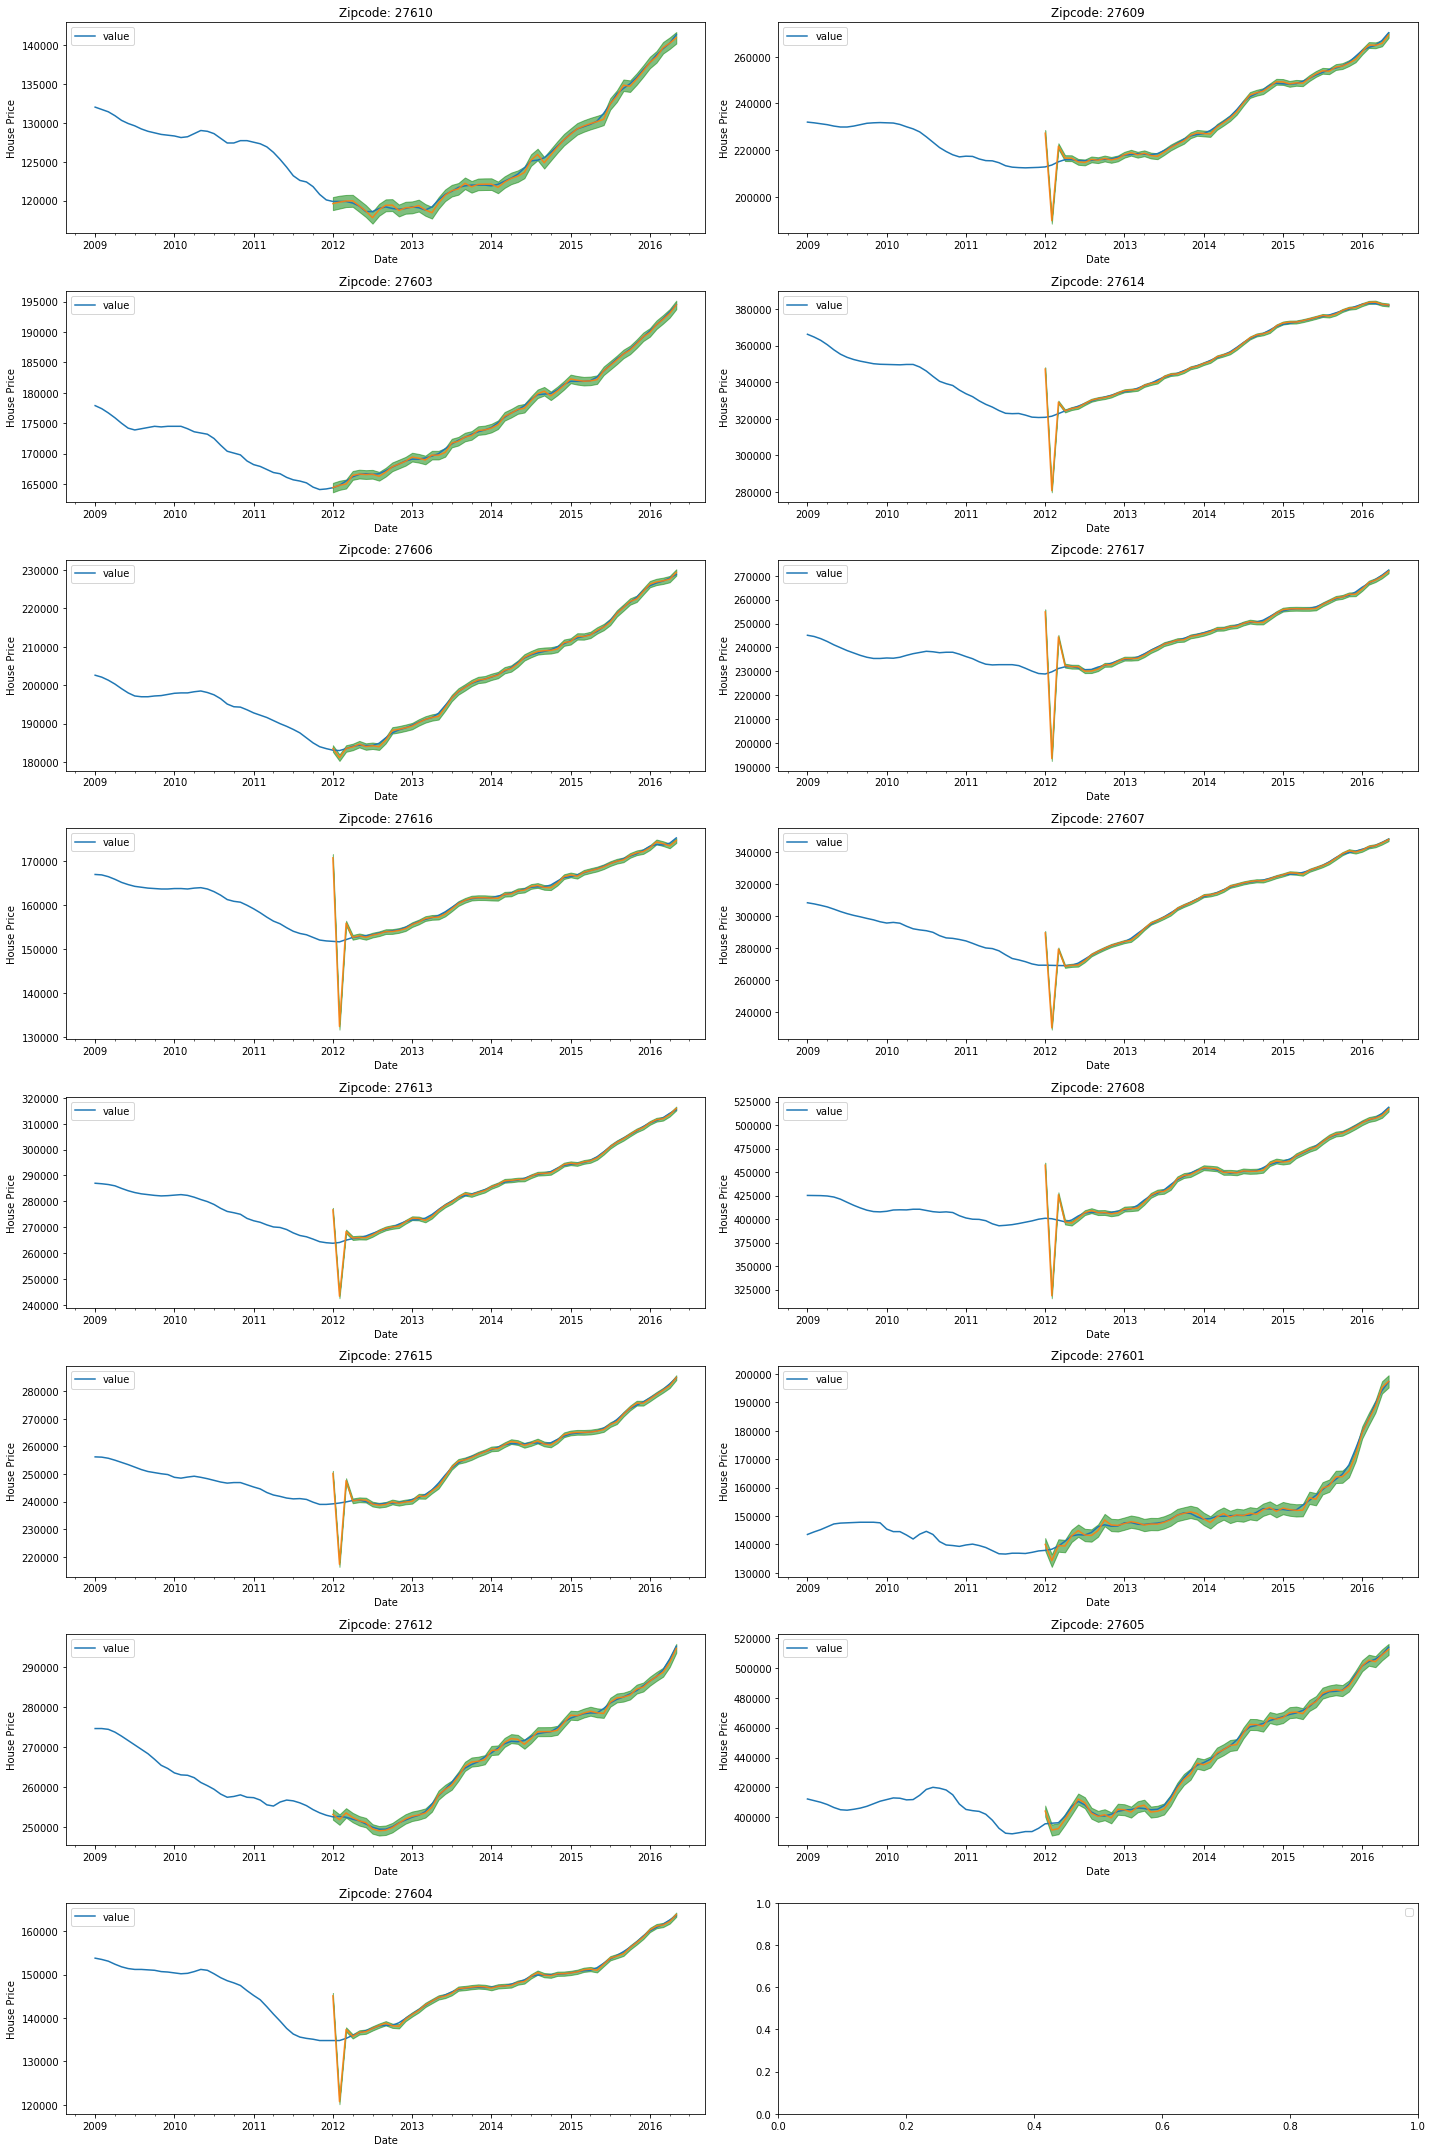

In [73]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

# specify subplot with each zipcode predicted/actual values 
for i in range(0,len(raleigh_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    # generate predictions for each zipcode, starting in 2012
    pred = raleigh_sarima[i].get_prediction(start='2012-01-01', dynamic=False)
    pred_conf = pred.conf_int()

    # predicted v. actual values
    raleigh_train[i].plot(label='observed', ax=ax)
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    
    # title, axis labels etc
    ax.set_title(f"Zipcode: {NCRzipcodes[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
    plt.legend(['Observed', 'Forecast'])    

plt.tight_layout()
plt.show()

In [74]:
# create empty list for rmse 
raleigh_rmses = []

for i in range(0, len(raleigh_train)):
    pred = raleigh_sarima[i].get_prediction(start='2009-01-01', dynamic=False)
    predictions = pred.predicted_mean
    rmse = np.sqrt(mean_squared_error(predictions, raleigh_train[i]))
    raleigh_rmses.append({'Zipcode': NCRzipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/raleigh_test[i]['2018-04']['value'][0])*100),2)})

In [75]:
raleigh_rmse_df = pd.DataFrame(raleigh_rmses)
raleigh_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
raleigh_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
13,19544.0,6.86,27601
8,32227.0,9.82,27609
2,26708.0,10.03,27606
0,17465.0,10.35,27610
1,23801.0,10.65,27603
11,43905.0,10.80,27607
12,61763.0,10.93,27608
6,38630.0,11.14,27612
7,21238.0,11.24,27604
4,39435.0,11.31,27613


In [76]:
raleigh_forecasts = []

for i in range(0, len(raleigh_test)):
    pred = raleigh_sarima[i].forecast(n-training_n)
    raleigh_forecasts.append(pred)

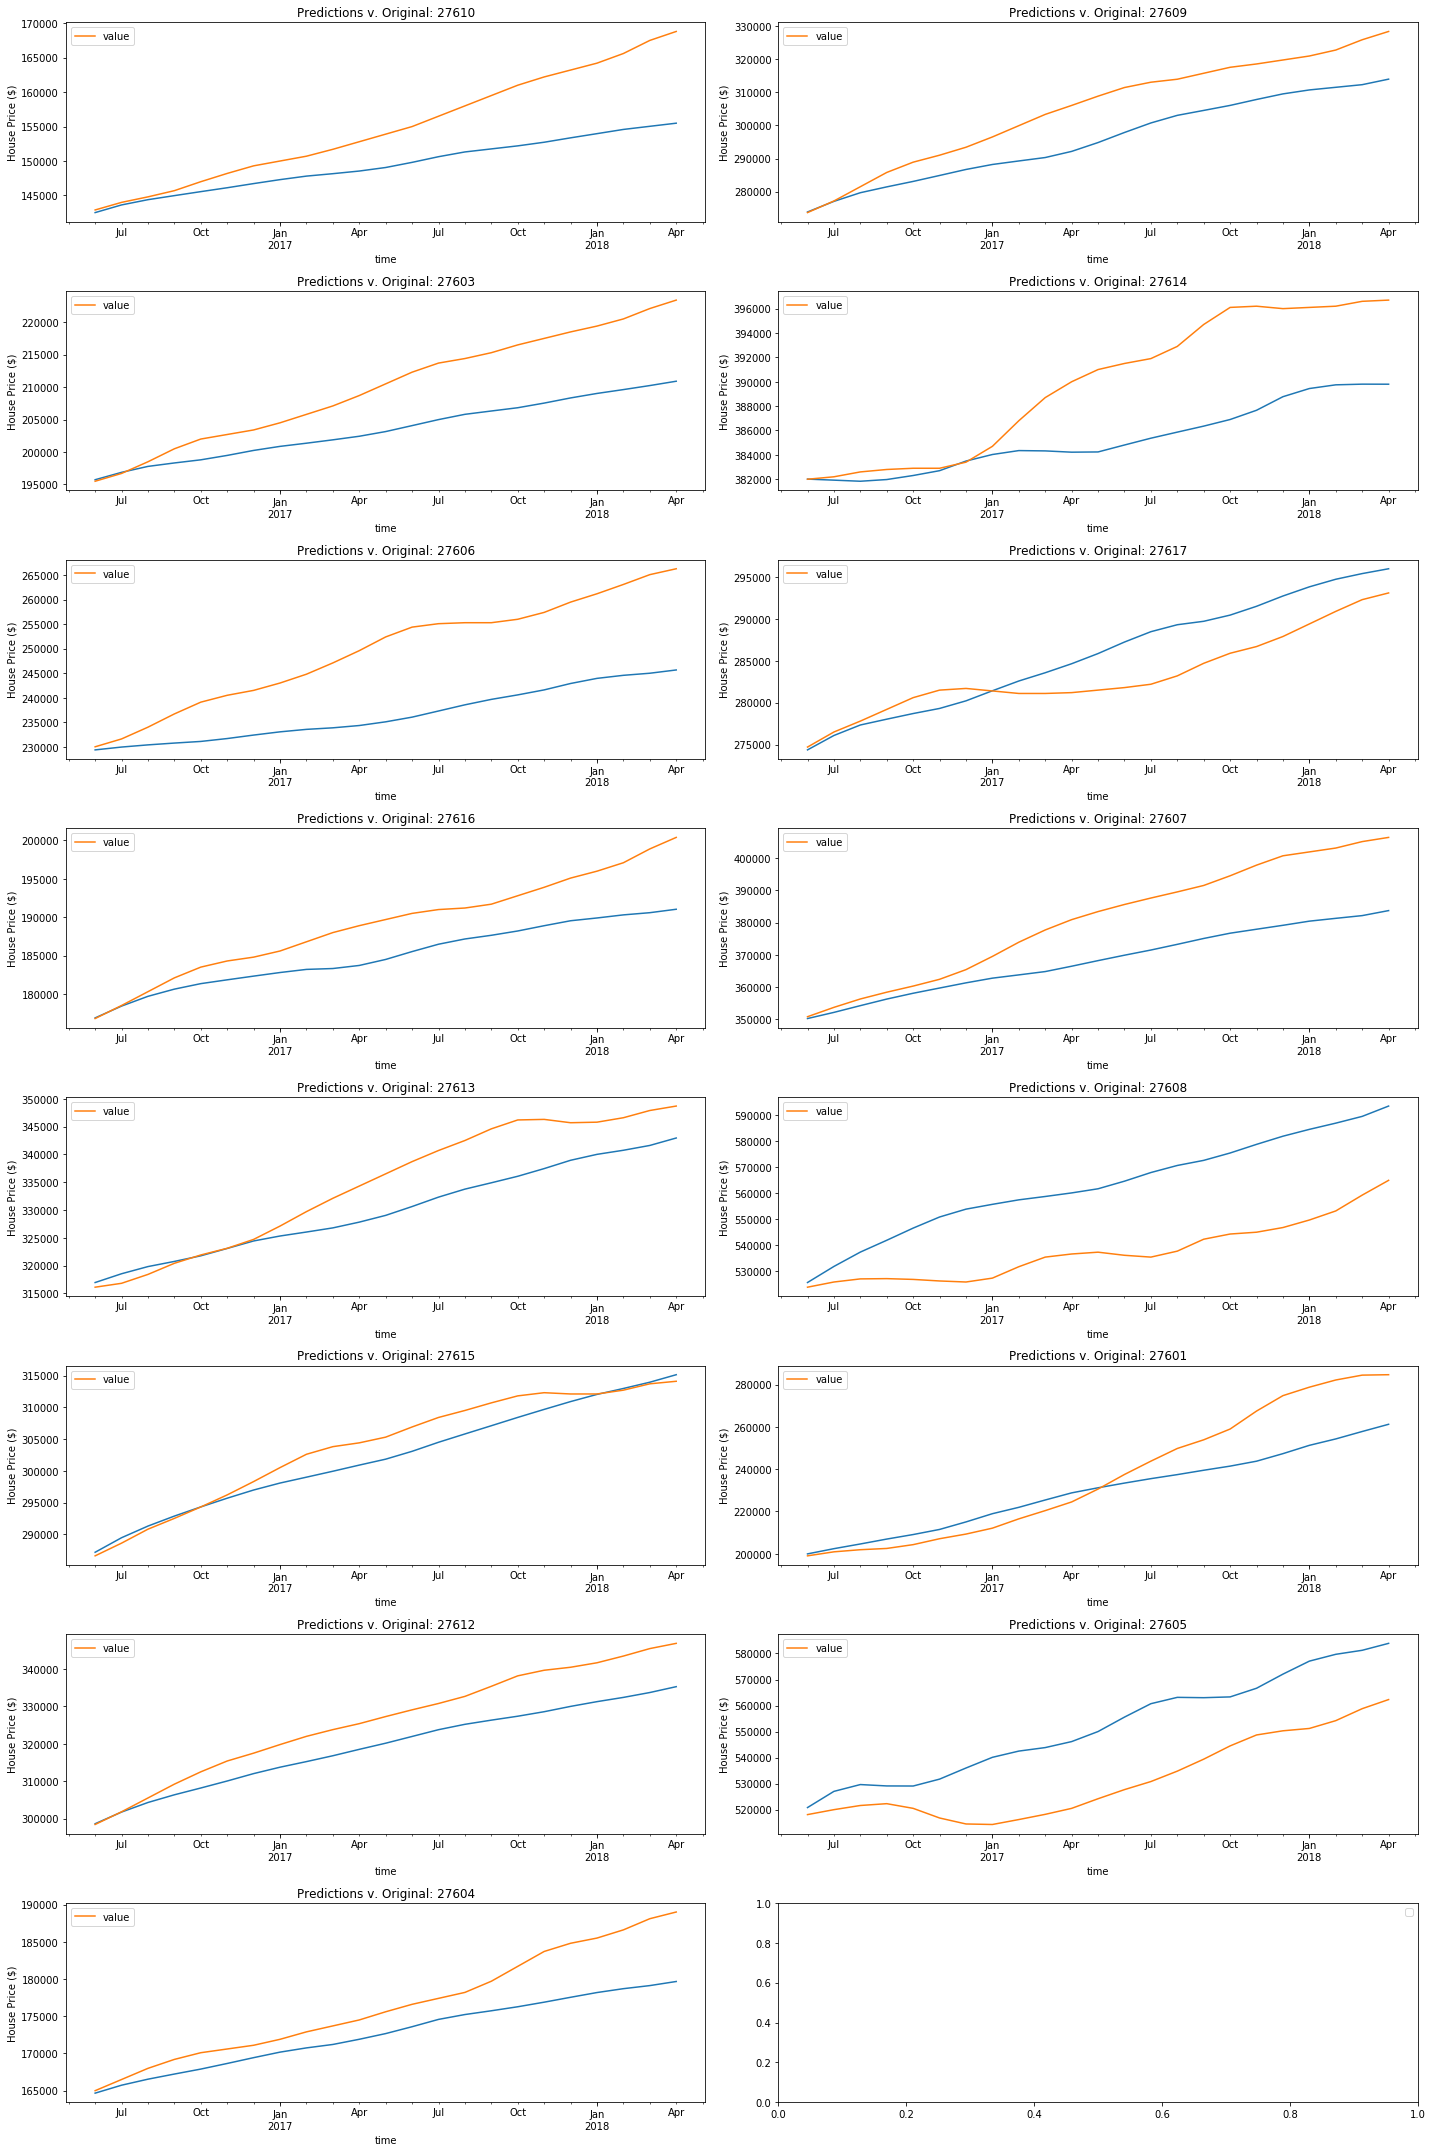

In [77]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(raleigh_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    raleigh_forecasts[i].plot(label='Predicted', ax=ax)
    raleigh_test[i].plot(label='Original', ax=ax)
    
    ax.set_title(f"Predictions v. Original: {NCRzipcodes[i]}")
    ax.set_ylabel('House Price ($)')
    plt.legend(['Predicted', 'Original'])

plt.tight_layout()
plt.show()

In [78]:
raleigh_rmses = []

for i in range(0, len(raleigh_test)):
    rmse = np.sqrt(mean_squared_error(raleigh_forecasts[i], raleigh_test[i]))
    raleigh_rmses.append({'Zipcode': NCRzipcodes[i], 'RMSE':round(rmse,0), 
                        'RMSE as % of 2018 House Price': round(((rmse/raleigh_test[i]['2018-04']['value'][0])*100),2)})

In [79]:
raleigh_test_rmse2 = pd.DataFrame(raleigh_rmses)
raleigh_test_rmse2.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
raleigh_test_rmse2

,RMSE,RMSE as % of 2018 House Price,Zipcode
5,2462.0,0.78,27615
10,3628.0,1.24,27617
9,5527.0,1.39,27614
4,5981.0,1.72,27613
6,7825.0,2.26,27612
3,4713.0,2.35,27616
7,4668.0,2.47,27604
8,10273.0,3.13,27609
1,7537.0,3.37,27603
11,14731.0,3.62,27607


__________

### Best Zipcodes - Orlando, Florida

In [81]:
# dictionary to include all zipcodes time series
orlando_dict = {}
    
# iterate over all the zipcodes within each city
for i in Orlando.Zipcode.unique():
    temp_zip_df = Orlando[Orlando.Zipcode == i]
    temp_zip_ts = melt_data(temp_zip_df)
    
    # adding timeseries to a dictionary
    orlando_dict[i] = temp_zip_ts

In [82]:
# keys should show zipcode list
orlando_dict.keys()

dict_keys([32822, 32828, 32825, 32839, 32837, 32835, 32824, 32812, 32807, 32817, 32806, 32803, 32832, 32801, 32804, 32826, 32829, 32827, 32814])

In [83]:
# test 
orlando_dict[32822].head(2)

,value
time,
2009-01-01,141500.0
2009-02-01,136500.0


In [84]:
# import plotly 
import plotly as py
import plotly.graph_objects as go

In [88]:
# plot zipcodes 
fig = go.Figure()
for i, key in enumerate(orlando_dict):
    fig.add_trace(go.Scatter(x=orlando_dict[key].index, y=orlando_dict[key].value, name=str(list(orlando_dict.keys())[i-1])))
fig.update_layout(title_text='Orlando Home Value by Zipcode',
                      xaxis_rangeslider_visible=False, showlegend=False)
fig.show()

In [89]:
# define function for two return with use of dictionary 
def calculate_returns(dictionary_of_zipcodes, years=0):
    
    if years==2:
        # calculate 2 year returns
        returns = {}
        for i, key in enumerate(dictionary_of_zipcodes):
            temp_return = (dictionary_of_zipcodes[key] - dictionary_of_zipcodes[key].shift(periods=24))/dictionary_of_zipcodes[key].shift(periods=24)*100
            temp_return.dropna(inplace=True)
            returns[list(dictionary_of_zipcodes.keys())[i-1]] = temp_return
            
        return returns


In [100]:
# define function to filter the top 5 zipcodes within the city 
def filter_zipcodes(returns_dict, years=0, city=''):
      
    # filter only 15 highest current return zipcodes
    temp_dict = {}
    for i, key in enumerate(returns_dict):
        temp_dict[list(returns_dict.keys())[i-1]] = returns_dict[key].iloc[-7:-1].values.mean()#calculating mean return for last 6 months
    #array to dataframe format - 5 largest returns        
    return_6months = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Mean Return'])
    return_6months = return_6months.nlargest(5, ['Mean Return']) 
    return_6months = pd.DataFrame(return_6months) 
    return_6months = return_6months.transpose()
    
    # plot results
    zipcodes = [z for z in return_6months.index]
    y_pos = np.arange(len(zipcodes))
    ax = return_6months.plot.bar(align='center', colormap='cool')
    plt.axhline(y=0, color='red', alpha=.5)
    plt.title(f'Best {city} Zipcodes to Invest for {years}-Year Period', fontsize=16)
    ax.set_ylabel('Mean Percentage')
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    plt.xticks([])
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # print results 
    print(return_6months)
    return return_6months

In [101]:
orlando_2years_returns = calculate_returns(orlando_dict, years=2)

In [102]:
orlando_2years_returns[32822].head(2)

,value
time,
2011-01-01,-23.080377
2011-02-01,-22.660550


                 32824      32828      32827      32807      32812
Mean Return  46.433181  40.191611  34.548961  28.561704  26.090202


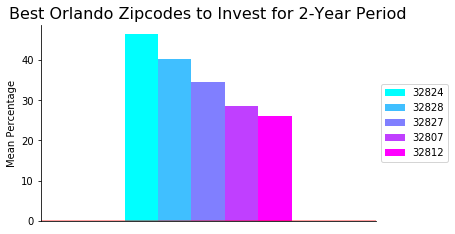

In [103]:
# filter the zipcodes with the highest mean return 
orlando_2years_filtered = filter_zipcodes(orlando_2years_returns, years=2, city='Orlando')

### Best Zipcodes - Raleigh, North Carolina

In [104]:
# dictionary to include all zipcodes time series
raleigh_dict = {}
    
# iterate over all the zipcodes within each city
for i in Raleigh.Zipcode.unique():
    temp_zip_df = Raleigh[Raleigh.Zipcode == i]
    temp_zip_ts = melt_data(temp_zip_df)
    
    # adding timeseries to a dictionary
    raleigh_dict[i] = temp_zip_ts

In [105]:
# keys should show zipcode list
raleigh_dict.keys()

dict_keys([27610, 27603, 27606, 27616, 27613, 27615, 27612, 27604, 27609, 27614, 27617, 27607, 27608, 27601, 27605])

In [106]:
# plot zipcodes 
fig = go.Figure()
for i, key in enumerate(raleigh_dict):
    fig.add_trace(go.Scatter(x=raleigh_dict[key].index, y=raleigh_dict[key].value, name=str(list(orlando_dict.keys())[i-1])))
fig.update_layout(title_text='Raleigh Home Value by Zipcode',
                      xaxis_rangeslider_visible=False, showlegend=False)
fig.show()

In [107]:
raleigh_2years_returns = calculate_returns(raleigh_dict, years=2)

                 27607      27612      27601      27613      27614
Mean Return  55.530541  22.969094  19.451442  19.362817  17.319729


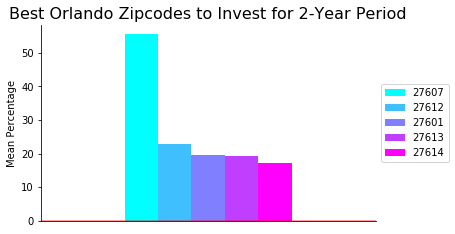

In [108]:
# filter the zipcodes with the highest mean return 
raleigh_2years_filtered = filter_zipcodes(raleigh_2years_returns, years=2, city='Orlando')

### Conclusion

Mercury has decided on two areas within the southern United States for which homeowners can invest in and they are: Orlando, Florida and Raleigh, North Carolina. The top three zipcodes within Orlando are 32824, 32828, and 32827 and the top two zipcodes in Raleigh are 27607 and 27612. These five zipcodes give the best two year investment for the prospective home buyer.

Future recommendations include surveying area where investments are going to be made. Take into consideration how well the area does economically as well as the job market. 